 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [ ]:
# !pip install torchvision

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

In [ ]:
!pip install torchmetrics

import torchvision.transforms as transforms
from torch.optim import Adam
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torchmetrics import Accuracy

import pandas as pd
import statistics
import math
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 14.1 MB/s eta 0:00:00


Скачаем обучающую и контрольную выборки.

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2000,
                                          shuffle=True, num_workers=10)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=2000,
                                         shuffle=False, num_workers=10)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

100%|██████████| 26421880/26421880 [00:02<00:00, 13182223.44it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 212415.46it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3799697.11it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13271221.26it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot|

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

#Смотрим на датасет

In [ ]:
print("Pics_in_train:", len(trainset))
print("Pics_in_test:", len(testset))

Pics_in_train: 60000
Pics_in_test: 10000


In [ ]:
_, counts_train = np.unique(trainloader.dataset.targets, return_counts=True)
counts_train

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [ ]:
_, counts_test = np.unique(testloader.dataset.targets, return_counts=True)
counts_test

array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])

В обоих датасетах количество объектов распределено равномерно

Ankle boot


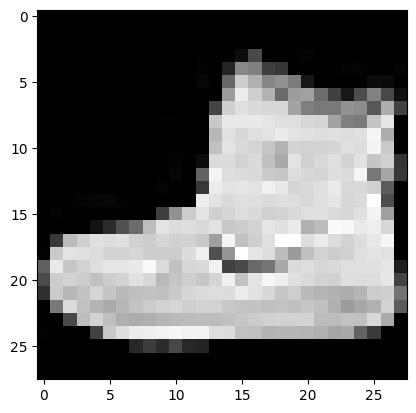

T-shirt/top


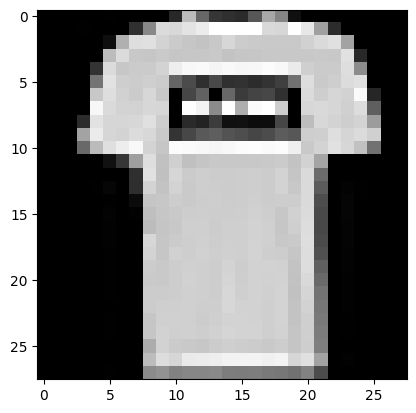

T-shirt/top


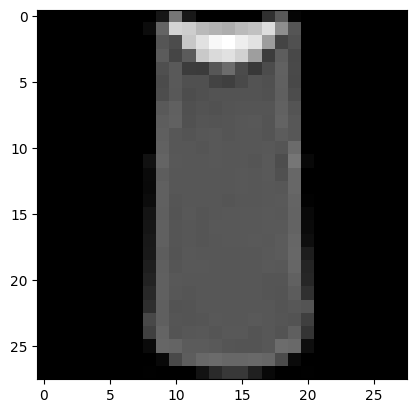

Dress


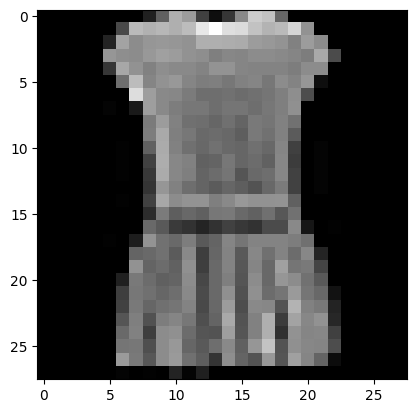

T-shirt/top


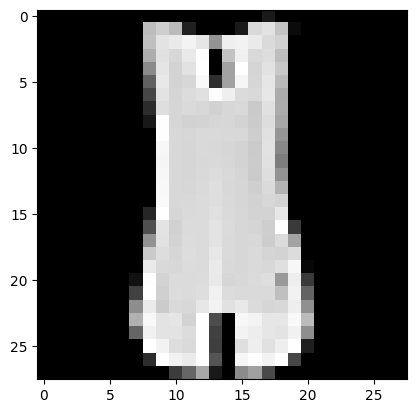

Pullover


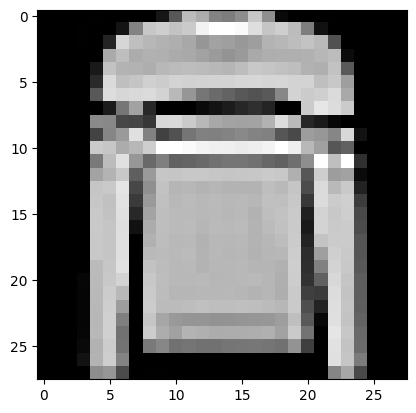

Sneaker


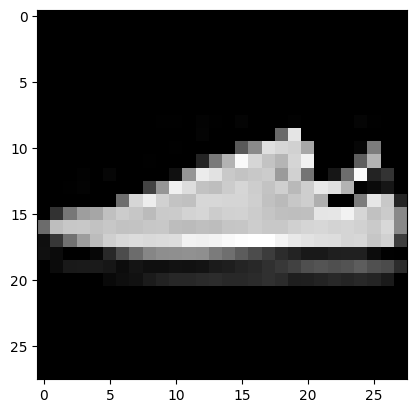

Pullover


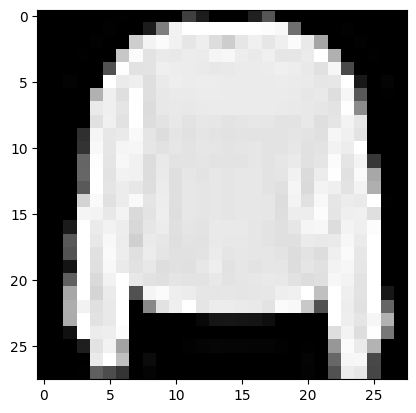

Sandal


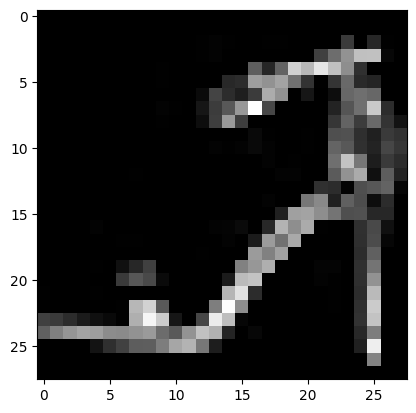

Sandal


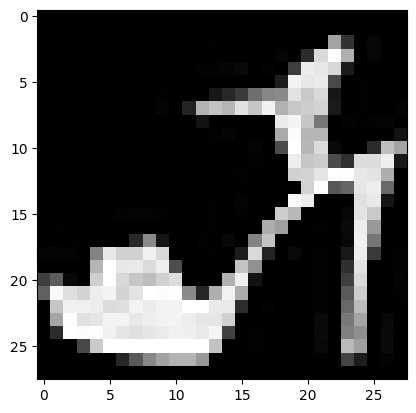

In [ ]:
for i in range(10):
  _, ax = plt.subplots()
  ax.imshow(trainset.train_data[i], cmap='gray')
  print(classes[trainloader.dataset.targets[i]])
  plt.show()

#Работаем с датасетом

In [ ]:
def train_and_test(model, loss_fn, optimizer, num_epoch = 30):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    best_params = 0
    best_epoch = 0
    best_accuracy = 0
    accuracy = Accuracy(task="multiclass", num_classes=10)

    for i in range(num_epoch):
      # Инициализация переменных для отслеживания потерь и точности во время обучения и тестирования
      train_loss = 0.0
      test_loss = 0.0
      train_acc = 0.0
      test_acc = 0.0
      runs = 0
      model.train()

      # Цикл обучения
      for data, target in trainloader:
        model.zero_grad()
        out = model(data)
        loss = loss_fn(out, target.view(-1))
        loss.backward()
        optimizer.step()

        # Оценка точности предсказаний
        accuracy_metric = accuracy(out.cpu(), target.cpu())

        # Накопление потерь и точности на обучающем наборе данных
        rain_loss += loss.item()
        train_acc += accuracy_metric.item()
        runs += 1

      # Расчет средних потерь и точности на обучающем наборе данных
      train_loss /= runs
      train_acc /= runs

      runs = 0
      model.eval() # Установка модели в режим оценки

      # Цикл тестирования
      for data, target in testloader:
          with torch.no_grad():
              out = model(data)
              loss = loss_fn(out, target.view(-1))

          # Оценка точности предсказаний
          accuracy_metric = accuracy(out.cpu(), target.cpu())

          # Накопление потерь и точности на тестовом наборе данных
          test_loss += loss.item()
          test_acc += accuracy_metric.item()
          runs += 1

      # Накопление потерь и точности на тестовом наборе данных
      test_loss /= runs
      test_acc /= runs

      # Сохранение значений потерь и точности на обучающем и тестовом наборах данных для визуализации или анализа
      train_losses.append(train_loss)
      train_accuracies.append(train_acc)
      test_losses.append(test_loss)
      test_accuracies.append(test_acc)

      # Обновление лучшей точности, лучших параметров модели и лучшей эпохи
      if test_acc > best_accuracy:
          best_accuracy = test_acc
          best_params = model.state_dict()
          best_epoch = i

      # Вывод номера текущей эпохи и точности на тестовом наборе данных
      print('Epoch: {} \tAccuracy: {:.6f}'.format(i+1, test_acc))

    # Загрузка лучших параметров модели
    model.load_state_dict(best_params)

    # Возврат обученной модели, значений потерь и точности на обучающем и тестовом наборах данных, лучшей эпохи и лучшей точности
    return model, train_losses, test_losses, train_accuracies, test_accuracies, best_epoch, best_accuracy

In [ ]:
class MLP(nn.Module):
    def __init__(self):
      super(MLP, self).__init__()
      self.__fc1 = nn.Sequential(
        nn.Linear(28 * 28, 256), # Линейный слой с 28 * 28 входами и 256 выходами
        nn.ReLU(), #функция активации
        nn.Dropout(0.1) # Перевыборка (dropout) с вероятностью 0.1
      )
      self.__fc2 = nn.Sequential(
        nn.Linear(256, 128), # Линейный слой с 256 входами и 128 выходами
        nn.ReLU(),
        nn.Dropout(0.1)
      )
      self.__fc3 = nn.Sequential(
        nn.Linear(128, 10) # Линейный слой с 128 входами и 10 выходами
      )


    def forward(self, x):
      x = x.view(-1, 28 * 28) # Изменение формы входа в пакеты и преобразование их в одномерный тензор
      x = self.__fc1(x)
      x = self.__fc2(x)
      x = self.__fc3(x)
      return x

In [ ]:
mlp = MLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(params=mlp.parameters())

In [ ]:
mlp, mlp_train_losses, mlp_test_losses, mlp_train_accuracies, mlp_test_accuracies, best_epoch, best_accuracy = train_and_test(mlp, loss_fn, optimizer, 100)

Epoch: 1 	Accuracy: 0.723800
Epoch: 2 	Accuracy: 0.801600
Epoch: 3 	Accuracy: 0.825300
Epoch: 4 	Accuracy: 0.834900
Epoch: 5 	Accuracy: 0.840600
Epoch: 6 	Accuracy: 0.849100
Epoch: 7 	Accuracy: 0.854200
Epoch: 8 	Accuracy: 0.855900
Epoch: 9 	Accuracy: 0.861300
Epoch: 10 	Accuracy: 0.864400
Epoch: 11 	Accuracy: 0.867000
Epoch: 12 	Accuracy: 0.867000
Epoch: 13 	Accuracy: 0.874100
Epoch: 14 	Accuracy: 0.868700
Epoch: 15 	Accuracy: 0.875400
Epoch: 16 	Accuracy: 0.877800
Epoch: 17 	Accuracy: 0.877200
Epoch: 18 	Accuracy: 0.880200
Epoch: 19 	Accuracy: 0.880700
Epoch: 20 	Accuracy: 0.881800
Epoch: 21 	Accuracy: 0.882400
Epoch: 22 	Accuracy: 0.880400
Epoch: 23 	Accuracy: 0.885600
Epoch: 24 	Accuracy: 0.882000
Epoch: 25 	Accuracy: 0.885900
Epoch: 26 	Accuracy: 0.885700
Epoch: 27 	Accuracy: 0.884400
Epoch: 28 	Accuracy: 0.885100
Epoch: 29 	Accuracy: 0.889900
Epoch: 30 	Accuracy: 0.886700
Epoch: 31 	Accuracy: 0.884100
Epoch: 32 	Accuracy: 0.889900
Epoch: 33 	Accuracy: 0.888900
Epoch: 34 	Accuracy

In [ ]:
print(f'Best epoch: {best_epoch}, best accuracy: {best_accuracy:.4f}')

Best epoch: 76, best accuracy: 0.9005


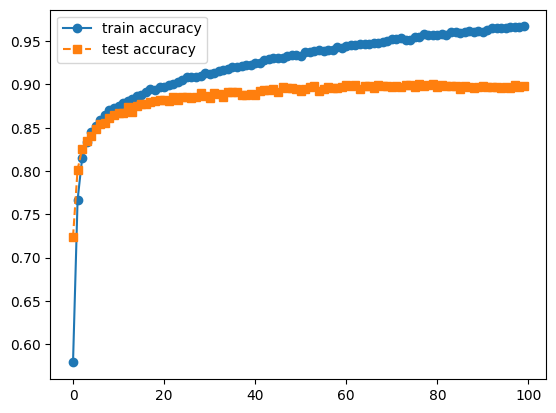

In [ ]:
plt.plot(mlp_train_accuracies, '-o', label = "train accuracy")
plt.plot(mlp_test_accuracies,'--s', label = "test accuracy")
plt.legend()
plt.show()

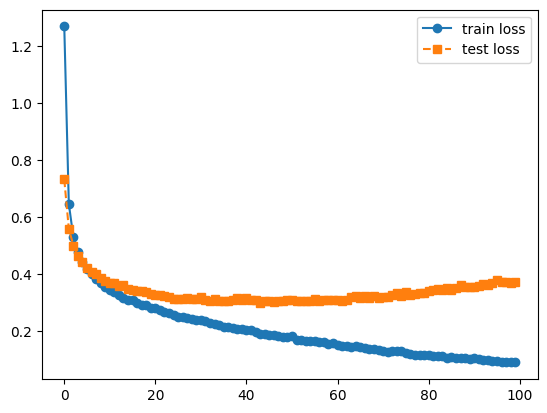

In [ ]:
plt.plot(mlp_train_losses, '-o', label = "train loss")
plt.plot(mlp_test_losses,'--s', label = "test loss")
plt.legend()
plt.show()

Удалось добиться результата в 90%, однако по графикам явно видно, что модель переобучилась, так как test acc вышла на плато, а test loss даже возросла под конец. Это, скорее всего, из-за слишком большого числа эпох, однако с этим можно справиться так же уменьшив количество слоев или увеличив dropout

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Определяем последовательность слоев свертки
        self.__conv = nn.Sequential(
            nn.Conv2d(1, 32, 3), # Сверточный слой с 1 входным каналом, 32 выходными каналами и размером ядра 3x3
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Пулинг слой с размером окна 2x2 и шагом 2
            nn.Dropout2d(0.4), # Dropout слой с вероятностью отключения нейрона 0.4
            nn.Conv2d(32, 64, 3), # Сверточный слой с 32 входными каналами, 64 выходными каналами и размером ядра 3x3
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Пулинг слой с размером окна 2x2 и шагом 2
            nn.Dropout2d(0.4), # Dropout слой с вероятностью отключения нейрона 0.4
        )

        # Определяем последовательность полносвязных слоев
        self.__dense = nn.Sequential(
            nn.Linear(64 * 5 * 5, 128), # Полносвязный слой с 64 * 5 * 5 входными нейронами и 128 выходными нейронами
            nn.ReLU(),
            nn.Dropout(0.4), # Dropout слой с вероятностью отключения нейрона 0.4
            nn.Linear(128, 10) # Полносвязный слой с 128 входными нейронами и 10 выходными нейронами
        )

    def forward(self, x):
        x = self.__conv(x) # Пропускаем входной тензор через последовательность слоев свертки
        x = x.view(-1, 64 * 5 * 5) # Переформатируем тензор в плоскую форму
        x = self.__dense(x) # Пропускаем плоский тензор через последовательность полносвязных слоев
        return x

In [ ]:
cnn = CNN()

optimizer = Adam(params=cnn.parameters())
loss_fn = nn.CrossEntropyLoss()

In [ ]:
cnn, cnn_train_losses, cnn_test_losses, cnn_train_accuracies,cnn_test_accuracies, best_epoch, best_accuracy = train_and_test(cnn, loss_fn, optimizer, 100)

Epoch: 1 	Accuracy: 0.743100
Epoch: 2 	Accuracy: 0.773300
Epoch: 3 	Accuracy: 0.808400
Epoch: 4 	Accuracy: 0.824300
Epoch: 5 	Accuracy: 0.834800
Epoch: 6 	Accuracy: 0.844100
Epoch: 7 	Accuracy: 0.853400
Epoch: 8 	Accuracy: 0.857600
Epoch: 9 	Accuracy: 0.861200
Epoch: 10 	Accuracy: 0.864900
Epoch: 11 	Accuracy: 0.867700
Epoch: 12 	Accuracy: 0.870300
Epoch: 13 	Accuracy: 0.876900
Epoch: 14 	Accuracy: 0.875300
Epoch: 15 	Accuracy: 0.878300
Epoch: 16 	Accuracy: 0.881900
Epoch: 17 	Accuracy: 0.881400
Epoch: 18 	Accuracy: 0.883600
Epoch: 19 	Accuracy: 0.887100
Epoch: 20 	Accuracy: 0.883000
Epoch: 21 	Accuracy: 0.886900
Epoch: 22 	Accuracy: 0.888200
Epoch: 23 	Accuracy: 0.885200
Epoch: 24 	Accuracy: 0.888400
Epoch: 25 	Accuracy: 0.892800
Epoch: 26 	Accuracy: 0.891500
Epoch: 27 	Accuracy: 0.892000
Epoch: 28 	Accuracy: 0.893300
Epoch: 29 	Accuracy: 0.892600
Epoch: 30 	Accuracy: 0.893200
Epoch: 31 	Accuracy: 0.894800
Epoch: 32 	Accuracy: 0.893800
Epoch: 33 	Accuracy: 0.896700
Epoch: 34 	Accuracy

In [ ]:
print(f'Best epoch: {best_epoch}, best accuracy: {best_accuracy:.4f}')

Best epoch: 94, best accuracy: 0.9160


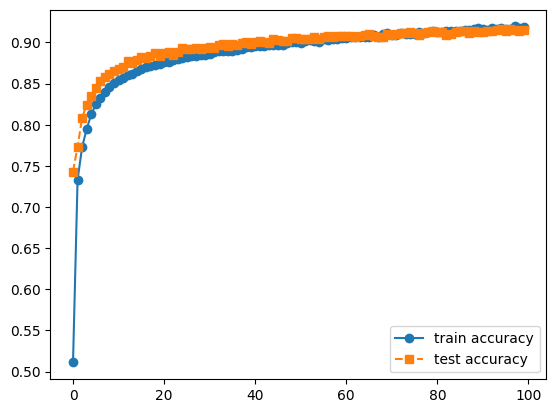

In [ ]:
plt.plot(cnn_train_accuracies, '-o', label = "train accuracy")
plt.plot(cnn_test_accuracies,'--s', label = "test accuracy")
plt.legend()
plt.show()

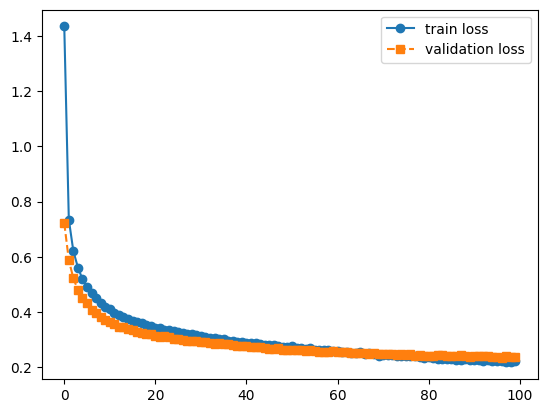

In [ ]:
plt.plot(cnn_train_losses, '-o', label = "train loss")
plt.plot(cnn_test_losses,'--s', label = "validation loss")
plt.legend()
plt.show()

Результат сверточной сети получился значительно лучше, примерно на 2%, но обучалась она значительно дольше. При этом графики тестовых данных не совсем вышли на плато, так что в теории точность может быть даже немного выше